# Essai NN

source : https://scottmduda.medium.com/fine-tuning-language-models-for-sentiment-analysis-91db72396549

github : https://github.com/dontmindifiduda/financial_statement_sentiment_analysis/

In [1]:


import numpy as np 
import pandas as pd 

import os
import re
import time
import datetime
import string

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter, defaultdict

import transformers
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import mlflow


### Chargement des données

In [2]:
# On Importe les données

#df
df_train=pd.read_parquet('/mnt/data/interim/df_train.gzip')
df_val=pd.read_parquet('/mnt/data/interim/df_val.gzip')
df_test=pd.read_parquet('/mnt/data/interim/df_test.gzip')

#X
X_train=pd.read_parquet('/mnt/data/interim/X_train.gzip')
X_val=pd.read_parquet('/mnt/data/interim/X_val.gzip')
X_test=pd.read_parquet('/mnt/data/interim/X_test.gzip')

X_train_prepro=pd.read_parquet('/mnt/data/interim/X_train_prepro.gzip')
X_val_prepro=pd.read_parquet('/mnt/data/interim/X_val_prepro.gzip')
X_test_prepro=pd.read_parquet('/mnt/data/interim/X_test_prepro.gzip')

#y
y_train=pd.read_parquet('/mnt/data/interim/y_train.gzip')
y_val=pd.read_parquet('/mnt/data/interim/y_val.gzip')
y_test=pd.read_parquet('/mnt/data/interim/y_test.gzip')

## Set Device and Apply Random Seed

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.concat([df_train, df_val, df_test], axis=0)


In [5]:

df['num_char'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

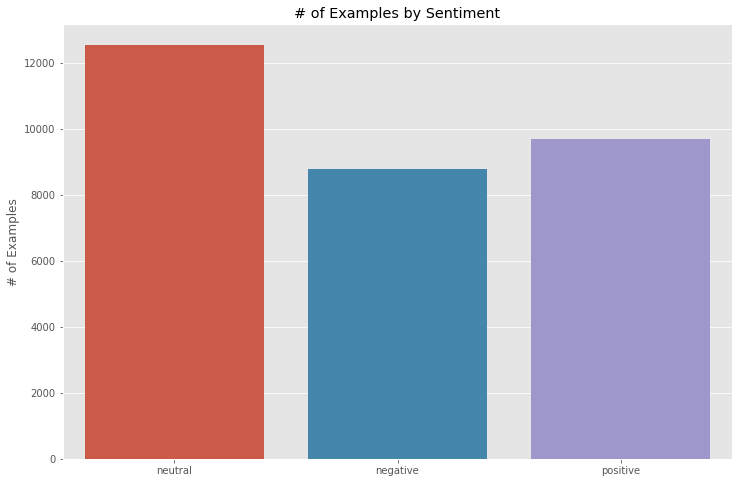

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='sentiment', data=df)
plt.xlabel('')
plt.ylabel('# of Examples')
plt.title('# of Examples by Sentiment')
plt.show()

In [7]:
print('Longest Statement: ', df['num_words'].max(), 'words.')

Longest Statement:  33 words.


In [8]:
print('Shortest Statement: ', df['num_words'].min(), 'words.')

Shortest Statement:  1 words.


# Sentiment analysis

In [9]:
MAX_LENGTH = 64
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 5
DROPOUT_PROB = 0.1
WEIGHT_DECAY = 0.01
NFOLDS = 10
LEARNING_RATE = 2e-5

In [10]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [11]:
class TweetDataset(Dataset):
    
    def __init__(self, tweets, labels, tokenizer, max_length):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        
        return len(self.tweets)
    
    def __getitem__(self, idx):
        
        tweet = str(self.tweets[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            tweet,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True, 
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  
        ) 
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
def create_dataset(df, tokenizer, max_length):
    ds = TweetDataset(tweets=df['text'].to_numpy(),
                          labels=df['sentiment'].to_numpy(),
                          tokenizer=tokenizer,
                          max_length=max_length)
    return ds

def create_dataloader(ds, batch_size):
    return DataLoader(ds, batch_size)#, num_workers=4)

In [13]:
def cv_ensemble_performance(preds, labels):
    preds = np.array(preds)
    summed = np.sum(preds, axis=0)
    preds = np.argmax(summed, axis=1)
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))
    
def single_model_performance(preds, labels):
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))

In [14]:
def train_model(model, device, data_loader, loss_function, 
                optimizer, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)
        complete_preds.append(preds.data.cpu().numpy().tolist())
        complete_labels.append(labels.data.cpu().numpy().tolist())
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    complete_preds_flat = [x for y in complete_preds for x in y]
    complete_labels_flat = [x for y in complete_labels for x in y]
    acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
    return acc_score, np.mean(losses)

In [15]:
def eval_model(model, device, data_loader, loss_function, n_examples):
    model = model.eval()
    
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    complete_outputs = []
    
    with torch.no_grad():
        for item in data_loader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)

            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, labels)
            
            correct_preds += torch.sum(preds == labels)
            complete_preds.append(preds.data.cpu().numpy().tolist())
            complete_labels.append(labels.data.cpu().numpy().tolist())
            complete_outputs.append(outputs.tolist())
            losses.append(loss.item())
        
        accuracy = correct_preds.double() / n_examples
        complete_preds_flat = [x for y in complete_preds for x in y]
        complete_labels_flat = [x for y in complete_labels for x in y]
        complete_outputs_flat = [x for y in complete_outputs for x in y]

        acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
        
        return_items = (acc_score, 
                        np.mean(losses),
                        complete_labels_flat,
                        complete_preds_flat, 
                        complete_outputs_flat)
        
        return return_items

In [16]:
def plot_cm(y_test, y_pred, target_names=[-1, 0, 1], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

In [17]:
import mlflow.pytorch
from mlflow.tracking import MlflowClient

In [18]:
def train_fold(mlf_XP, xp_name_iter, epochs, model, device, train_dataloader, 
               val_dataloader, test_dataloader, loss_fn, optimizer, 
               scheduler, model_save_name, n_train, n_val, single_model=True):
    
    
    mlflow.set_experiment(mlf_XP)

    
    
    start_time = time.time()
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        run_name = xp_name_iter + '_' + str(epoch+1)
        with mlflow.start_run(run_name = run_name):
            epoch_start_time = time.time()
            print('Epoch ', epoch+1, '/', epochs)
            print('-'*50)

            training_output = train_model(model, 
                                          device, 
                                          train_dataloader, 
                                          loss_fn, 
                                          optimizer, 
                                          scheduler, 
                                          n_train)

            train_acc, train_loss = training_output

            val_output = eval_model(model, 
                                    device, 
                                    val_dataloader, 
                                    loss_fn, 
                                    n_val)

            val_acc, val_loss, _, val_preds, val_outputs = val_output

            history['train_accuracy'].append(train_acc)
            history['train_loss'].append(train_loss)
            history['val_accuracy'].append(val_acc)
            history['val_loss'].append(val_loss)
            history['val_preds'].append(val_preds)
            
            mlflow.log_metrics({'epoch': epoch, 'train_acc' : train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss' : val_loss })
            
            mlflow.pytorch.log_model(model, run_name, conda_env='/mnt/configs/conda.yml')
            
            if val_acc > best_accuracy:
                torch.save(model.state_dict(), model_save_name)
                best_accuracy = val_acc
                best_preds = val_preds
                best_outputs = val_outputs
                best_epoch = epoch
                

            print('Train Loss: ', 
                  train_loss, 
                  ' | ', 
                  'Train Accuracy: ', 
                  train_acc)
            print('Val Loss: ', 
                  val_loss, 
                  ' | ', 
                  'Val Accuracy: ', 
                  val_acc)
            elapsed_time = format_time(time.time() - epoch_start_time)
            print('Epoch Train Time: ', 
                  elapsed_time)
            print('\n')
            
            mlflow.set_tag(key="elapsed_time", value=elapsed_time)   

    print('Finished Training.')   
    print('Fold Train Time: ', format_time(time.time() - start_time))
    print('\n')
                  
    if single_model:
        test_acc, test_loss, test_actuals, test_preds, test_outputs = eval_model(model, 
                                                    device, 
                                                    test_dataloader, 
                                                    loss_function, 
                                                    len(df_test))

        single_model_performance(test_preds, df_test['sentiment'].values)
        plot_cm(test_actuals, test_preds)
        f1_macro_test = f1_score(test_actuals, test_preds, average='macro')
        run_name = xp_name_iter + '_best'
        with mlflow.start_run(run_name = run_name):
            mlflow.log_metrics({'train_acc' : history['train_accuracy'][epoch], 'train_loss': history['train_accuracy'][epoch], 'val_acc': history['val_accuracy'][epoch], 'val_loss' : history['train_accuracy'][epoch], 'test_acc': test_acc, 'test_loss': test_loss, 'f1_test':f1_macro_test})
            mlflow.pytorch.log_model(model, run_name, conda_env='/mnt/configs/conda.yml')

                  
    return history, best_preds, best_outputs

In [19]:
def get_oof_and_test_preds(mlf_XP, model_type, tokenizer, 
                           train_df, test_df, single_model=False):
    
    
    mlflow.set_experiment(mlf_XP)
    
    
    oof_preds = []
    oof_outputs = []
    oof_preds_indices = []
    test_preds_list = []
    test_outputs_list = []
    history_list = []
    start_time = time.time()
    
    fold = 0
    
    x_train = train_df['text']
    y_train = train_df['sentiment']

    for train_index, val_index in skf.split(x_train, y_train):
        print('Fold: {}'.format(fold+1))
        
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_va = x_train.iloc[val_index]
        y_va = y_train.iloc[val_index]
        
        train = pd.DataFrame(list(zip(x_tr, y_tr)), 
                             columns=['text', 'sentiment'])
        val = pd.DataFrame(list(zip(x_va, y_va)), 
                           columns=['text', 'sentiment'])

        train_ds = create_dataset(train, tokenizer, MAX_LENGTH)
        val_ds = create_dataset(val, tokenizer, MAX_LENGTH)
        test_ds = create_dataset(test_df, tokenizer, MAX_LENGTH)
        

        if model_type == 'bert':
            model = BERTSentimentClassifier(NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'distilbert':
            model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, 
                                                        num_classes=NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'roberta':
            model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
            model = model.to(device)
        
        train_loader = create_dataloader(train_ds, BATCH_SIZE)
        val_loader = create_dataloader(val_ds, BATCH_SIZE)
        test_loader = create_dataloader(test_ds, BATCH_SIZE)
        
        training_steps = len(train_loader.dataset) * EPOCHS
        warmup_steps = int(0.1 * training_steps)
        optimizer = AdamW(model.parameters(), 
                          lr=LEARNING_RATE, 
                          weight_decay=WEIGHT_DECAY, 
                          correct_bias=True)
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=warmup_steps, 
                                                    num_training_steps=training_steps)
        
        model_save_name = '{}_fold_{}.bin'.format(model_type, fold)
        
        history, preds, outputs = train_fold(mlf_XP = mlf_XP, 
                                             xp_name_iter = model_type + '_Fold' + str(fold+1),
                                             epochs=EPOCHS,
                                             model=model, 
                                             device=device, 
                                             train_dataloader=train_loader, 
                                             val_dataloader=val_loader,
                                             test_dataloader=test_loader,
                                             loss_fn=loss_function,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             model_save_name=model_save_name,
                                             n_train=len(train),
                                             n_val=len(val),
                                             single_model=False
                                            )
        
        history_list.append(history)
        oof_preds.append(preds)
        oof_outputs.append(outputs)
        oof_preds_indices.append(val_index)
        
        test_acc, test_loss, test_actuals, test_preds, test_outputs = eval_model(model, 
                                                                                device, 
                                                                                test_loader, 
                                                                                loss_function, 
                                                                                len(test_df))
        test_preds_list.append(test_preds)
        test_outputs_list.append(test_outputs)
        
        fold += 1

    print(str(NFOLDS), 'Fold CV Train Time: ', format_time(time.time() - start_time))

    return history_list, test_outputs_list

In [20]:
loss_function = nn.CrossEntropyLoss().to(device)

In [21]:
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)

## Données

:::{warning}
On est obligé de recoder les sorties car laisser un label cible négatif génère une erreur `CUDA error: device-side assert triggered`
cf [lien](https://discuss.pytorch.org/t/runtimeerror-cuda-error-device-side-assert-triggered/34213/8)
:::

In [22]:
le = LabelEncoder()
df_train['sentiment'] = le.fit_transform(df_train['sentiment'])
df_val['sentiment'] = le.fit_transform(df_val['sentiment'])
df_test['sentiment'] = le.fit_transform(df_test['sentiment'])

In [23]:
df_train

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
21979,No allowed a calculator for this exam despite ...,0
21980,Haha same as miine,1
21981,"i`m sorry people are so rude to you, isaac, ...",0
21982,"why? i enjoy fancy meals on my own smtimes, t...",2


In [24]:
df_val

,text,sentiment
21984,_JessicaB_**** yip.....aw gonna miss them on bb,0
21985,_violence heyyyy babyy,0
21986,Up at 6am on Sunday... Going to meet my mom fo...,1
21987,so the Today show still hasn`t gotten in touch...,1
21988,Just checked email and got a follower withb sa...,1
...,...,...
27475,wish we could come see u on Denver husband l...,0
27476,I`ve wondered about rake to. The client has ...,0
27477,Yay good for both of you. Enjoy the break - y...,2
27478,But it was worth it ****.,2


In [25]:
df_train_full = pd.concat([df_train, df_val])
df_train_full

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27475,wish we could come see u on Denver husband l...,0
27476,I`ve wondered about rake to. The client has ...,0
27477,Yay good for both of you. Enjoy the break - y...,2
27478,But it was worth it ****.,2


## DistilBERT

### Single Model

In [81]:
DISTILBERT_MODEL_NAME = 'distilbert-base-uncased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [82]:
distilbert_train_ds = create_dataset(df_train, distilbert_tokenizer, MAX_LENGTH)
distilbert_test_ds = create_dataset(df_test, distilbert_tokenizer, MAX_LENGTH)
distilbert_val_ds = create_dataset(df_val, distilbert_tokenizer, MAX_LENGTH)

distilbert_train_dataloader = create_dataloader(distilbert_train_ds, BATCH_SIZE)
distilbert_test_dataloader = create_dataloader(distilbert_test_ds, BATCH_SIZE)
distilbert_val_dataloader = create_dataloader(distilbert_val_ds, BATCH_SIZE)

In [83]:
distilbert_train_ds

In [84]:
class DistilBertForSequenceClassification(nn.Module):

    def __init__(self, pretrained_model_name, num_classes):

        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "No Attention Mask"
        distilbert_output = self.distilbert(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)

        hidden_state = distilbert_output[0]  
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)  
        pooled_output = nn.ReLU()(pooled_output)  
        pooled_output = self.dropout(pooled_output)  
        logits = self.classifier(pooled_output)  

        return logits

In [85]:
distilbert_model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, num_classes=NUM_CLASSES)
distilbert_model = distilbert_model.to(device)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [86]:
training_steps = len(distilbert_train_dataloader.dataset) * EPOCHS

distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
distilbert_scheduler = get_linear_schedule_with_warmup(distilbert_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)

In [87]:
device

device(type='cuda')

In [88]:
distilbert_history, distilbert_preds, distilbert_outputs = train_fold(mlf_XP='BERT', 
                                                                       xp_name_iter='DistilBERT',
                                                                       epochs=EPOCHS,
                                                                       model=distilbert_model,
                                                                       device=device, 
                                                                       train_dataloader=distilbert_train_dataloader, 
                                                                       val_dataloader=distilbert_val_dataloader,
                                                                       test_dataloader=distilbert_test_dataloader,
                                                                       loss_fn=loss_function,
                                                                       optimizer=distilbert_optimizer,
                                                                       scheduler=distilbert_scheduler,
                                                                       model_save_name='distilbest_best_model.bin',
                                                                       n_train=len(df_train),
                                                                       n_val=len(df_val),
                                                                       single_model=True
                                                                      )

Epoch  1 / 5
--------------------------------------------------


KeyboardInterrupt: 

In [63]:
len(distilbert_history)

5

In [62]:
len(distilbert_preds)

5496

In [61]:
len(distilbert_outputs)

5496

In [71]:
df_test

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,1
1,Shanghai is also really exciting (precisely -...,2
2,"Recession hit Veronique Branquinho, she has to...",0
3,happy bday!,2
4,http://twitpic.com/4w75p - I like it!!,2
...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",0
3530,All alone in this old house again. Thanks for...,2
3531,I know what you mean. My little dog is sinkin...,0
3532,_sutra what is your next youtube video gonna b...,2


In [72]:
df_train_full

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27475,wish we could come see u on Denver husband l...,0
27476,I`ve wondered about rake to. The client has ...,0
27477,Yay good for both of you. Enjoy the break - y...,2
27478,But it was worth it ****.,2


### 10-Fold CV¶

In [74]:
distilbert_history, distilbert_test_outputs = get_oof_and_test_preds(mlf_XP='DistilBERT_10Fold',
                                                                     model_type='distilbert', 
                                                                     tokenizer=distilbert_tokenizer, 
                                                                     train_df=df_train_full, 
                                                                     test_df=df_test,
                                                                     single_model=False)

Fold: 1
Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.941926259658315  |  Train Accuracy:  0.522400129387029
Val Loss:  0.6203636002055434  |  Val Accuracy:  0.7558224163027657
Epoch Train Time:  0:02:25


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.580964529094073  |  Train Accuracy:  0.7636665049328805
Val Loss:  0.5477447283649167  |  Val Accuracy:  0.7776564774381368
Epoch Train Time:  0:02:18


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.5048014043286964  |  Train Accuracy:  0.7982371017305515
Val Loss:  0.545227823259179  |  Val Accuracy:  0.7900291120815138
Epoch Train Time:  0:02:16


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.44333723517084184  |  Train Accuracy:  0.8298964903768398
Val Loss:  0.5853824304893266  |  Val Accuracy:  0.7863901018922853
Epoch Train Time:  0:02:15


Epoch  5 / 5
--------------------------------------------------

In [75]:
cv_ensemble_performance(distilbert_test_outputs, df_test['sentiment'].values)

[[ 739  235   27]
 [ 148 1123  159]
 [  20  165  918]]

              precision    recall  f1-score   support

    negative      0.815     0.738     0.775      1001
     neutral      0.737     0.785     0.761      1430
    positive      0.832     0.832     0.832      1103

    accuracy                          0.787      3534
   macro avg      0.795     0.785     0.789      3534
weighted avg      0.789     0.787     0.787      3534



In [36]:
df_train

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
21979,No allowed a calculator for this exam despite ...,0
21980,Haha same as miine,1
21981,"i`m sorry people are so rude to you, isaac, ...",0
21982,"why? i enjoy fancy meals on my own smtimes, t...",2


In [37]:
df_train.groupby('sentiment').count()

,text
sentiment,
0,6195
1,8849
2,6940


In [38]:
df_test.groupby('sentiment').count()

,text
sentiment,
0,1001
1,1430
2,1103


## BERT

### Single Model

In [36]:
BERT_MODEL_NAME = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [37]:
bert_train_ds = create_dataset(df_train, bert_tokenizer, MAX_LENGTH)
bert_test_ds = create_dataset(df_test, bert_tokenizer, MAX_LENGTH)
bert_val_ds = create_dataset(df_val, bert_tokenizer, MAX_LENGTH)

bert_train_dataloader = create_dataloader(bert_train_ds, BATCH_SIZE)
bert_test_dataloader = create_dataloader(bert_test_ds, BATCH_SIZE)
bert_val_dataloader = create_dataloader(bert_val_ds, BATCH_SIZE)

In [29]:
i=0
for batch in bert_train_dataloader:
    i+=1
    if i<3:
        print(batch)
        print('\n---------------------\n')

{'tweet_text': [' I`d have responded, if I were going', ' Sooo SAD I will miss you here in San Diego!!!', 'my boss is bullying me...', ' what interview! leave me alone', ' Sons of ****, why couldn`t they put them on the releases we already bought', 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth', '2am feedings for the baby are fun when he is all smiles and coos', 'Soooo high', ' Both of you', ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)', ' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff', 'I really really like the song Love Story by Taylor Swift', 'My Sharpie is running DANGERously low on ink', 'i want to go to music tonight but i lost my voice.', 'test test from the LG enV2', 'Uh oh, I am sunburned'], 'input_ids': tensor([[  101,   146,   169,  ...,     0,     0,     0],
        [  101, 27972,  1186,  ...,     0,     0,     0],
        [  101,  1139,  60

In [35]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.model = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        
        return self.output(output)


In [38]:
bert_model = BERTSentimentClassifier(NUM_CLASSES)
bert_model = bert_model.to(device)

In [39]:
training_steps = len(bert_train_dataloader.dataset) * EPOCHS

bert_optimizer = AdamW(bert_model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY, 
                       correct_bias=True)

warmup_steps = int(0.1 * training_steps)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps=warmup_steps, 
                                                 num_training_steps=training_steps)

In [40]:
device

device(type='cuda')

In [42]:
bert_model

BERTSentimentClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [56]:
bert_single_model_items = train_fold(mlf_XP='BERT', 
                                     xp_name_iter='BERT',
                                     epochs=EPOCHS, 
                                     model=bert_model, 
                                     device=device, 
                                     train_dataloader=bert_train_dataloader, 
                                     val_dataloader=bert_val_dataloader,
                                     test_dataloader=bert_test_dataloader,
                                     loss_fn=loss_function,
                                     optimizer=bert_optimizer,
                                     scheduler=bert_scheduler,
                                     model_save_name='bert_best_model.bin',
                                     n_train=len(df_train),
                                     n_val=len(df_val),
                                     single_model=True
                                    )

Epoch  1 / 5
--------------------------------------------------


TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str

### 10-Fold CV¶

In [72]:
bert_history, bert_test_outputs = get_oof_and_test_preds(mlf_XP='BERT_10Fold',
                                                         model_type='bert', 
                                                         tokenizer=bert_tokenizer, 
                                                         train_df=df_train_full, 
                                                         test_df=df_test,
                                                         single_model=False)

INFO: 'BERT_10Fold' does not exist. Creating a new experiment
Fold: 1
Epoch  1 / 5
--------------------------------------------------


TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str

# Essai FF

source : https://huggingface.co/transformers/training.html

In [43]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [44]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")

classes = ["not paraphrase", "is paraphrase"]

sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"

# The tokekenizer will automatically add any model specific separators (i.e. <CLS> and <SEP>) and tokens to the sequence, as well as compute the attention masks.
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [49]:
!pip install datasets

     |████████████████████████████████| 237 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 9.8 MB/s  eta 0:00:011
     |████████████████████████████████| 128 kB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 41.0 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 20.3 MB/s  eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.56.2
    Uninstalling tqdm-4.56.2:
      Successfully uninstalled tqdm-4.56.2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [50]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


In [51]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [52]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [53]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 50000
    })
})

In [54]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]


In [55]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## roBERTa


Single Model¶

In [75]:
ROBERTA_MODEL_NAME = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [76]:
roberta_train_ds = create_dataset(df_train, roberta_tokenizer, MAX_LENGTH)
roberta_test_ds = create_dataset(df_test, roberta_tokenizer, MAX_LENGTH)
roberta_val_ds = create_dataset(df_val, roberta_tokenizer, MAX_LENGTH)

roberta_train_dataloader = create_dataloader(roberta_train_ds, BATCH_SIZE)
roberta_test_dataloader = create_dataloader(roberta_test_ds, BATCH_SIZE)
roberta_val_dataloader = create_dataloader(roberta_val_ds, BATCH_SIZE)

In [77]:
class RobertaSentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(RobertaSentimentClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME)
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )
        
        output = self.drop(pooled_output)
        
        return self.output(output)

In [78]:
roberta_model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
roberta_model = roberta_model.to(device)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [79]:
training_steps = len(roberta_train_dataloader.dataset) * EPOCHS

roberta_optimizer = AdamW(roberta_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)


In [80]:
roberta_single_model_items = train_fold(mlf_XP='BERT', 
                                        xp_name_iter='BERT',
                                        epochs=EPOCHS,
                                        model=roberta_model,
                                        device=device, 
                                        train_dataloader=roberta_train_dataloader, 
                                        val_dataloader=roberta_val_dataloader,
                                        test_dataloader=roberta_test_dataloader,
                                        loss_fn=loss_function,
                                        optimizer=roberta_optimizer,
                                        scheduler=roberta_scheduler,
                                        model_save_name='roberta_best_model.bin',
                                        n_train=len(df_train),
                                        n_val=len(df_val),
                                        single_model=True
                                        )

Epoch  1 / 5
--------------------------------------------------


TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str